# Hands On ML Chapter 7 - Ensemble Learning and Random Forests

In [30]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.datasets import make_moons, load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.tree import DecisionTreeClassifier

Ensemble Learning - choose group of best classifiers, train each of them on different subset of the training set. To make predictions you take predictions of classifiers and you choose class that is predicted mostly.

## Voting Classifiers

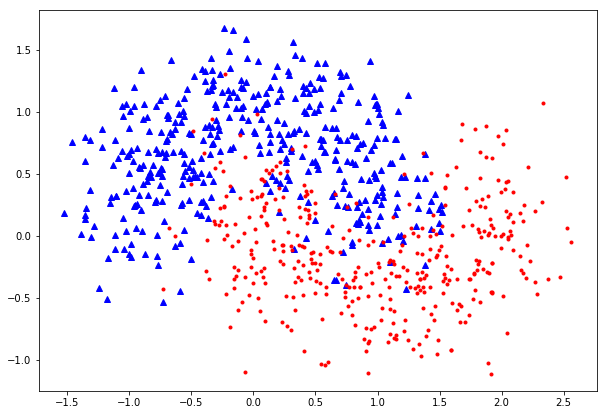

In [2]:
moons = make_moons(n_samples = 1000, noise=0.3)
X_train, X_test, y_train, y_test = train_test_split(moons[0], moons[1], test_size=0.2)
plt.figure(figsize=(10,7))
plt.plot(X_train[:,0][y_train==0], X_train[:,1][y_train==0], 'b^')
plt.plot(X_train[:,0][y_train==1], X_train[:,1][y_train==1], 'r.')

In [3]:
log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC(probability=True)

voting_clf = VotingClassifier(
    estimators=[
        ('lr', log_clf),
        ('rf', rnd_clf),
        ('svc', svm_clf)
    ],
    voting='soft'
)

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomF...',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False))],
         n_jobs=1, voting='soft', weights=None)

In [4]:
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.875
RandomForestClassifier 0.845
SVC 0.87
VotingClassifier 0.87


## Bagging and Pasting

https://www.youtube.com/watch?v=2Mg8QD0F1dQ

In [5]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators = 500, max_samples=100, bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.87

### Out-of-Bag Evaluation

When you use Bagging for classifying training set, for each predictor around 60% of instances are used. It means that for each predictor you have around 40% of set to evaluate your predictions.

In [6]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators = 500, max_samples=100, bootstrap=True, n_jobs=-1,
                           oob_score=True
                           )
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.90874999999999995

In [7]:
y_pred = bag_clf.predict(X_test)
bag_clf.oob_score_, accuracy_score(y_test, y_pred)

(0.90874999999999995, 0.86499999999999999)

## Random Patches and Random Subspaces

With BaggingClassifiers you can not only sample training instances but also features. With feature sampling each predictor will be trained on a random subset of input features. When you sample both features and instances it is called Random Patches. Keeping all training instances but sampling features is called Random Subspaces.

## Random Forests

Random Forest is an ensemble of Decision Trees. Instead of using BaggingClassifier() you can use RandomClassifier() which is better.

With a few exceptions RandomForestClassifier() has all the hyperparameters of DecisionTreeClassifier() and BaggingClassifier()

In [8]:
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)
y_pred = rnd_clf.predict(X_test)

### Feature Importance

With RandomForestClassifier it is easy to find important features.

In [9]:
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators = 500, n_jobs = -1)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.100302386339
sepal width (cm) 0.0217788999946
petal length (cm) 0.418292218992
petal width (cm) 0.459626494675


The most important features are petal length and width with 45% and 42%.

## Boosting

Boosting combine several weak learnes into stronger learner. It trains predictors sequentially, each trying to correct its predecessor.

### AdaBoost

In [12]:
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=200, algorithm="SAMME.R", learning_rate=0.5)
ada_clf.fit(X_train, y_train)
y_pred = ada_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.84999999999999998

### GradientBoosting

In [77]:
gb_clf = GradientBoostingClassifier(max_depth=3, n_estimators=30, learning_rate=0.5)
gb_clf.fit(X_train, y_train)
y_pred = gb_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.85499999999999998

#### Early stopping - staged_predict()

In [83]:
accuracies = [accuracy_score(y_test, y_pred) for y_test in gb_clf.staged_predict(X_test)]

In [85]:
bst_n_estimators = np.argmax(accuracies)

In [86]:
gb_clf_best = GradientBoostingClassifier(max_depth=2, n_estimators=bst_n_estimators)
gb_clf_best.fit(X_train, y_train)
y_pred = gb_clf_best.predict(X_test)
accuracy_score(y_test, y_pred)

0.90000000000000002

#### Early stopping - warm_start()

In [128]:
gb_clf = GradientBoostingClassifier(max_depth=1, warm_start=True)
max_val_accuracy = 0
accuracy_going_up = 0

for n_estimators in range(1, 120):
    gb_clf.n_estimators = n_estimators
    gb_clf.fit(X_train, y_train)
    y_pred = gb_clf.predict(X_test)
    val_accuracy = accuracy_score(y_test, y_pred)
    if val_accuracy > max_val_accuracy:
        max_val_accuracy = val_accuracy
        accuracy_going_up = 0
    else:
        accuracy_going_up += 1
        if accuracy_going_up == 20:
            break
            
print(max_val_accuracy)

0.9
